# Implementing a toy language : interpreter and compiler



In order to decompose the interpreter and compiler building process as much as
possible, we will decompose our task into a number of "languages" with increasing capabilities :
1. **const** : only one numerical constant (of integral type).
2. **addsub** : additions and subtraction.
3. **addmult** : additions, subtractions, multiplications and division, with priorities
4. **arith** : same as *addmult*, with parenthesis.
5. **lang0** : any number of expressions that can be either arithmetic expressions for the *arith* language or assignment of the result of such an expression into a variable. Expressions can also use variables. The code returns the value of the last expression.
6. **lang1** : same as *lang0* with arguments written as `%0`, `%1`,…

For each of these languages we will provide two execution models :
1. /interpretation/ : the code is turned into a function that evaluates the AST when called.
2. /compilation/ : the code is turned into a function that calls a static method from a dynamically compiled class.


First getting the dependencies from maven (might take some time, so one has to wait until the final output before going further).

In [1]:
%classpath add mvn rhizome rhizome 0.2.9
%classpath add mvn instaparse instaparse 1.4.9
;; with leiningen one would have a project.clj with
;;
;;(defproject languages "0.1.0-SNAPSHOT"
;;  :description "FIXME: write description"
;;  :url "http://example.com/FIXME"
;;  :license {:name "Eclipse Public License"
;;            :url "http://www.eclipse.org/legal/epl-v10.html"}
;;  :dependencies [[org.clojure/clojure "1.8.0"]
;;                 [instaparse "1.4.9"]
;;                 [rhizome "0.2.9"]])


null

## **Const** language

If we only ever wanted to parse integers, of course we would just use `Integer.pasreInt()` or actually `Long.parseLong()`. However, as this is just a stepping stone to more interesting languages, we will use the same infrastructure of parsing and then interpreting or compiling.


### Parser
When represented as a string of characters, integers are a string of one or more digits possibly prefixed by a minus sign for negative numbers.

One could write the following parsing rule using only literal terminals :
`number= '-'? ('0'|'1'|'2'|'3'|'4'|'5'|'6'|'7'|'8'|'9')+`

Note that this will accept leading zeros while we could also want to forbid them.
Parsing the string `"-123"` would give the following result :`[:number "-" "1" "2" "3"]`
So it would be up to the AST processing step to collate those strings before turning them into a number.

In order to speed both the parsing and the processing of our numbers, we can /tokenize/ them with a regular expression instead :
`NUMBER= #'-?[0-9]+'`
In Clojure, we can build the parser using the instaparse library :

In [2]:
(use 'instaparse.core)
(def const-parser
  (instaparse.core/parser
   "PROG= NUMBER
    NUMBER= #'-?[0-9]+'"))
    
(prn (const-parser "-123"))

[:PROG [:NUMBER "-123"]]


null

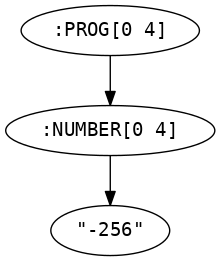

In [3]:
(System/setProperty "java.awt.headless" "true");; required for the notebook
(use 'rhizome.viz)
(instaparse.core/visualize (const-parser "-256") :output-file :buffered-image )

But this minimal parser fails to parse strings that we would want to consider valid :

In [5]:
(prn (const-parser "    -123456    "))

Parse error at line 1, column 1:
    -123456    
^
Expected:
#"-?[0-9]+" (followed by end-of-string)



null

As we want to handle spaces before and after the number, we have to modify the grammar accordingly. For efficiency reasons, we also handle the plurality of consecutive spaces at the lexing stage with a regular expression :

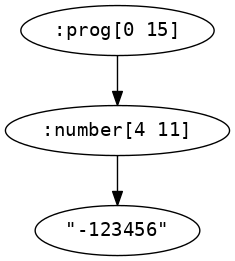

In [13]:
(def const-parser
  (instaparse.core/parser
   "prog= spaces number spaces
    number=#'-?[0-9]+'
    <spaces> = <#'[ ]'*>"))
    
(instaparse.core/visualize (const-parser "    -123456    ") :output-file :buffered-image )

Exercice : What if we remove the angle brackets in the grammar rules ?

## **const** interpreter

The simplest interpreter would be something like :

In [10]:
 (defn const-interpreter [ast]
   (instaparse.core/transform {:number #(Long/parseLong %)} ast))

#'beaker_clojure_shell_ddbffbe4-4ba9-43f7-9f75-f9843886e374/const-interpreter

In [14]:
 (prn (-> "-123" const-parser const-interpreter))

[:prog -123]


null

However, as we will want reuse code between the various languages, we will
separate the language specific transform map and a generic function to turn an
AST into a clojure function.

The generic function taking a transform map and returning the function turning an
AST into a clojure function : 

In [16]:
(defn dynamic-eval [interpreter]
    (fn[ast]
      (fn[]
        (instaparse.core/transform interpreter ast))))

#'beaker_clojure_shell_ddbffbe4-4ba9-43f7-9f75-f9843886e374/dynamic-eval

We can use this function for our **const** language to create a `const-eval`
function that will turn an AST into a clojure function:

In [17]:
(def const-interpreting
  {:prog identity
   :number #(Long/parseLong %)})
(def const-eval (dynamic-eval const-interpreting))

#'beaker_clojure_shell_ddbffbe4-4ba9-43f7-9f75-f9843886e374/const-eval

This function can be called on the result of parsing a string :

In [18]:
(def const-eval-test (-> "-123 " const-parser const-eval))

#'beaker_clojure_shell_ddbffbe4-4ba9-43f7-9f75-f9843886e374/const-eval-test

The result can then be called like any other clojure function :

In [19]:
(const-eval-test)

-123

## const compiler
The compiler will be implemented in two steps :
- turning the AST into a sequence of vectors. Each vector representing a
  bytecode instruction and the parameters, if any, of the instruction.
- generating a class with a static method implementing the bytecodes sequence
  , dynamically loading this class and returning a clojure function calling the static method of the generated
  class.


###  Generating the instructions sequence
As we will be processing an AST, we can do this with a transform map :

In [20]:
(def const-compiling
  {:prog (fn[& instrs](conj (reduce into [[:loadi 0]] instrs)[:reti]))
   :number #(vector [:loadi (Long/parseLong %)])})

#'beaker_clojure_shell_ddbffbe4-4ba9-43f7-9f75-f9843886e374/const-compiling

In [3]:
(prn as-and-bs);; prn is mandatory to get a display in the notebook

S = AB*
AB = A B
A = "a"+
B = "b"+



null

In [22]:
(use '[clojure.java.shell :only [sh]]) ;; checking graphviz is installed and useable
(prn (sh "dot" "-V"))

{:exit 0, :out "", :err "dot - graphviz version 2.38.0 (20140413.2041)\n"}


null

In [23]:
(use 'rhizome.dot);; this works

null

In [24]:
(System/setProperty "java.awt.headless" "true");; required for the notebook
(use 'rhizome.viz)

java.lang.Exception:  namespace 'rhizome.viz' not found

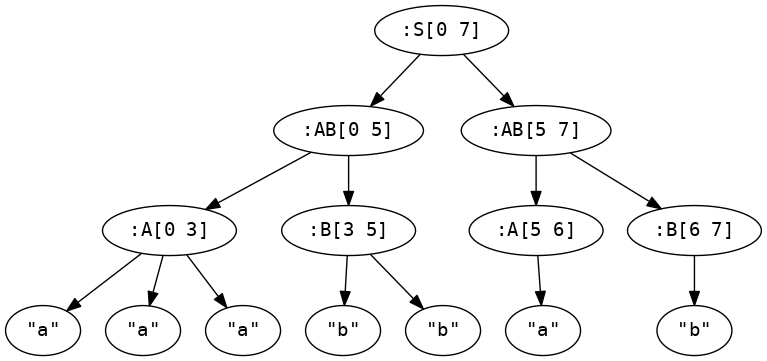

In [8]:
(instaparse.core/visualize (as-and-bs "aaabbab") :output-file :buffered-image )

## EasyForm

In [15]:
(def form (doto (com.twosigma.beakerx.easyform.EasyForm. "Test Form")
                (.addTextField "Name")
                (.addButton "Reverse" "reverse")))
form

In [16]:
(reverse (get form "Name"))

[l, l, i, r, d,  , a,  , s, i,  , s, i, h, T]

## Import magic command

In [23]:
%import clojure.asm.Opcodes
%import clojure.asm.Type
%import clojure.asm.ClassWriter

%import clojure.asm.commons.Method
%import clojure.asm.commons.GeneratorAdapter

In [25]:
%import com.twosigma.beakerx.widget.IntSlider

In [26]:
(new IntSlider)